# Base Path

In [1]:
# set home directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

# Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
from fastprogress import progress_bar

In [3]:
from utilities.utils import *
from utilities.scaleFunctions import *
from utilities.pcaFunctions import *
from utilities.pathManager import fetchPaths
from utilities.MonitorBDD import MonitorBDD

In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Paths

In [5]:
# DATASET = 'MNIST'
# DATASET = 'FashionMNIST'
DATASET = 'GTSRB'

LHLs = {
    'MNIST': 60,
    'FashionMNIST': 60,
    'GTSRB': 50
}


LHL = LHLs[DATASET]

In [6]:
# read dataset configs
paths = fetchPaths(base, DATASET, '', False)

path_data = paths['data']
path_saved_model = paths['saved_models'].parent

configs = load_json(paths['configuration'])
config = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']
optim_name = list(config['optimizer'].keys())[0]
optim_args = config['optimizer'][optim_name]
scheduler_name = list(config['scheduler'].keys())[0]
scheduler_args = config['scheduler'][scheduler_name]
batch_size = model_config['batch_size']

In [7]:
# construct NN model name and approperiate pathes

POSTFIX = f'{optim_name}-{batch_size}-{LHL}'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

paths = fetchPaths(base, DATASET, POSTFIX, False)
path_lhl = paths['lhl']

saved_model = list(path_saved_model.glob(f"*/{FILENAME_POSTFIX}-acc*.pth.tar"))[0]
feature_names = get_labels(DATASET)

FILENAME_POSTFIX

'GTSRB_AdamW-32-50'

## Load Data

In [8]:
# set flavor
flavor = 'raw' # raw, pca

# read LHL data
df_train = pd.read_csv(path_lhl / flavor / f"{FILENAME_POSTFIX}_{flavor}_train.csv")
df_test = pd.read_csv(path_lhl / flavor / f"{FILENAME_POSTFIX}_{flavor}_test.csv")
df_eval = pd.read_csv(path_lhl / flavor / f"{FILENAME_POSTFIX}_{flavor}_evaluation.csv")

# select all true classified
df_true = pd.concat([df_train[df_train["true"] == True].copy(), df_test[df_test["true"] == True].copy()])
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

# select only true classified
# df_true = df_train[df_train["true"] == True].copy()
# df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_true.shape

(65661, 51)

In [9]:
# load scaler and pca
scaler_ = load_pickle(path_lhl / 'scaler.pkl')
pca_ = load_pickle(path_lhl / 'pca.pkl')

# load selected neurons
gte_mean = load_json(path_lhl / 'neurons_gte_mean.json')
top_third = load_json(path_lhl / 'neurons_top_third.json')

## Construct Monitor

In [10]:
MonitorConfig = {
    'threshold': 'Median', # ReLU, Mean, Median, 25%-Q, 75%-Q
    'neuron_selection': 'GTE Mean', # None, GTE Mean, Top Third
    'eta': 0
}

In [11]:
# translate MonitorConfig to numbers
thld_p = {'Median': 0.5, '25%-Q': 0.25, '75%-Q': 0.75, 'ReLU': 0, 'Mean': 1}
thld_p = thld_p[MonitorConfig['threshold']]

eta = MonitorConfig['eta']

neurons = {'None': [], 'GTE Mean': gte_mean, 'Top Third': top_third}
neurons = neurons[MonitorConfig['neuron_selection']]

if flavor=='pca' and neurons!=[]:
    nerons = [f'x{i}' for i in range(numComponents(pca_))]

# calculate threshold
if thld_p == 1:
    thld = np.mean( df_true.drop('y', axis=1), axis=0)
if thld_p == 0:
    thld = np.zeros(df_true.drop('y', axis=1).shape[1])
else:
    thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)

In [12]:
# start timer
st = time.perf_counter()
 
# construct Monitor
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons, reorder=False, memory=10)
# build + evaluate
df_train_copy, df_test_copy, df_eval_copy = patterns.add_dataframe(
    df_true, eta, eval_dfs=[df_train.copy(), df_test.copy(), df_eval.copy()] )

# stop timer
en = round(int(time.perf_counter() - st) / 60, 3)

# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
df_eval_scores = patterns.score_dataframe_multi_eta(df_eval_copy, eta)

# add metadata
patterns.stats['num_observations'] = df_true.shape[0]

print('Time to construct: ', en, 'min')

Time to construct:  0.05 min


In [13]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,NaN,0.0,0.0,147.1,0.0,65661.0,40.6,0.0,25.0,2023-11-14 12:36:49,2023-11-14 12:36:50,65661


In [14]:
df_train_scores.loc[ df_train_scores['y'] == 'all', df_train_scores.columns[:-3]]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity
43,all,63968.0,2345.0,2101.0,2101.0,0.0,0.032845,1.0,0.895949


In [15]:
df_test_scores.loc[ df_test_scores['y'] == 'all', df_test_scores.columns[:-3]]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity
43,all,4192.0,154.0,139.0,139.0,0.0,0.033158,1.0,0.902597


In [16]:
df_eval_scores.loc[ df_eval_scores['y'] == 'all', ['total_count','unrecognized_and_classified','NPR']]

,total_count,unrecognized_and_classified,NPR
1,1000.0,977.0,0.977


## Visualize Threshold Location

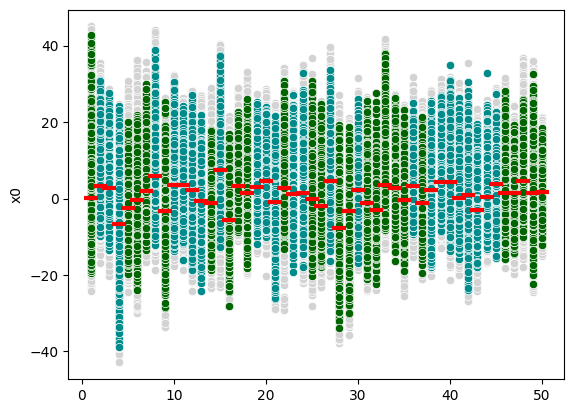

In [19]:
for i, c in enumerate(df_true.columns[:-1]):
    sns.scatterplot( x=i+1,  y=df_true[c], c='lightgray')

# Test Data
for i, c in enumerate(df_test.columns[:-2]):
    sns.scatterplot( x=i+1,  y=df_test[c], c='darkgreen' if c in neurons else 'darkcyan')

sns.scatterplot(
    x=[*range(1, df_true.shape[1])],
    y=thld,
    marker='_', s=100, c='red', linewidth=3
)

plt.xlabel('')
plt.show()